In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0333

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - loss: 0.0233
Average validation loss: 0.6925825476646423
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 536ms/step - loss: 0.0233 - val_loss: 0.6926
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 502ms/step - loss: 0.0152 - val_loss: 0.6926
Average validation loss: 0.5611432790756226
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 510ms/step - loss: 0.0152 - val_loss: 0.6269
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 505ms/step - loss: 0.0107 - val_loss: 0.6269
Average validation loss: 0.4509342908859253
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 517ms/step - loss: 0.0107 - val_loss: 0.5682
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 785ms/step - loss: 1.0657e-05
Average validation loss: 0.2541702091693878
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 798ms/step - loss: 1.0657e-05 - val_loss: 0.2542
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 776ms/step - loss: 1.0239e-05 - val_loss: 0.2542
Average validation loss: 0.16140703856945038
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - loss: 1.0239e-05 - val_loss: 0.2078
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 813ms/step - loss: 9.9802e-06 - val_loss: 0.2078
Average validation loss: 0.13010457530617714
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 823ms/step - loss: 9.9802e-06 - val_loss: 0.1819
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_s

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 798ms/step - loss: 4.1447e-06
Average validation loss: 0.09428322811921437
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - loss: 4.1447e-06 - val_loss: 0.0943
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 772ms/step - loss: 3.7949e-06 - val_loss: 0.0943
Average validation loss: 0.06888056670626004
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 785ms/step - loss: 3.7949e-06 - val_loss: 0.0816
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 769ms/step - loss: 3.5669e-06 - val_loss: 0.0816
Average validation loss: 0.07949019471804301
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 783ms/step - loss: 3.5669e-06 - val_loss: 0.0809
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 796ms/step - loss: 3.5778e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 818ms/step - loss: 3.9377e-07
Average validation loss: 0.02751930500380695
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 828ms/step - loss: 3.9377e-07 - val_loss: 0.0275
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 855ms/step - loss: 3.5536e-07 - val_loss: 0.0275
Average validation loss: 0.015983468270860612
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 866ms/step - loss: 3.5536e-07 - val_loss: 0.0218
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 820ms/step - loss: 3.1745e-07 - val_loss: 0.0218
Average validation loss: 0.03406863636337221
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 830ms/step - loss: 3.1745e-07 - val_loss: 0.0259
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 53s 815ms/step - loss: 2.7826e-

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 875ms/step - loss: 6.0569e-07
Average validation loss: 0.029416007921099663
20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 885ms/step - loss: 6.0569e-07 - val_loss: 0.0294
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 793ms/step - loss: 4.5627e-07 - val_loss: 0.0294
Average validation loss: 0.020026149041950703
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 806ms/step - loss: 4.5627e-07 - val_loss: 0.0247
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 762ms/step - loss: 3.5126e-07 - val_loss: 0.0247
Average validation loss: 0.03878983967006207
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 775ms/step - loss: 3.5126e-07 - val_loss: 0.0294
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 761ms/step - loss: 2.8527e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 816ms/step - loss: 7.5817e-07
Average validation loss: 0.019560150724525254
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 826ms/step - loss: 7.5817e-07 - val_loss: 0.0196
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 805ms/step - loss: 5.5761e-07 - val_loss: 0.0196
Average validation loss: 0.02086158349023511
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 819ms/step - loss: 5.5761e-07 - val_loss: 0.0202
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 785ms/step - loss: 4.5883e-07 - val_loss: 0.0202
Average validation loss: 0.012275111124229928
24/24 ━━━━━━━━━━━━━━━━━━━━ 59s 799ms/step - loss: 4.5883e-07 - val_loss: 0.0176
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_30.pth'.
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 77s 774ms/step - loss: 3.7043e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 800ms/step - loss: 7.2632e-07
Average validation loss: 0.019177145569119602
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 812ms/step - loss: 7.2632e-07 - val_loss: 0.0192
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 779ms/step - loss: 4.7573e-07 - val_loss: 0.0192
Average validation loss: 0.01619677464477718
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 792ms/step - loss: 4.7573e-07 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 782ms/step - loss: 3.6432e-07 - val_loss: 0.0177
Average validation loss: 0.02102231401950121
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 794ms/step - loss: 3.6432e-07 - val_loss: 0.0188
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 783ms/step - loss: 2.9445e

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 7.9568e-07
Average validation loss: 0.03137797765278568
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 818ms/step - loss: 7.9568e-07 - val_loss: 0.0314
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 787ms/step - loss: 8.0005e-07 - val_loss: 0.0314
Average validation loss: 0.03822566460197171
48/48 ━━━━━━━━━━━━━━━━━━━━ 78s 799ms/step - loss: 8.0005e-07 - val_loss: 0.0348
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 815ms/step - loss: 6.8955e-07 - val_loss: 0.0348
Average validation loss: 0.017770015149532508
48/48 ━━━━━━━━━━━━━━━━━━━━ 117s 827ms/step - loss: 6.8955e-07 - val_loss: 0.0291
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_60.pth'.
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 852ms/step - loss: 5.848

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 812ms/step - loss: 5.3490e-07
Average validation loss: 0.04511843768081495
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 824ms/step - loss: 5.3490e-07 - val_loss: 0.0451
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 90s 784ms/step - loss: 4.0220e-07 - val_loss: 0.0451
Average validation loss: 0.028373836539685726
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 796ms/step - loss: 4.0220e-07 - val_loss: 0.0367
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 783ms/step - loss: 3.1058e-07 - val_loss: 0.0367
Average validation loss: 0.01756974176636764
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 795ms/step - loss: 3.1058e-07 - val_loss: 0.0304
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 789ms/step - loss: 4.7456e-08
Average validation loss: 0.010324032133212313
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 801ms/step - loss: 4.7456e-08 - val_loss: 0.0103
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 777ms/step - loss: 3.8458e-08 - val_loss: 0.0103
Average validation loss: 0.00917531520826742
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 788ms/step - loss: 3.8458e-08 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 777ms/step - loss: 3.6512e-08 - val_loss: 0.0097
Average validation loss: 0.009076043264940381
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 788ms/step - loss: 3.6512e-08 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 779ms/step - loss: 2.2939e-08
Average validation loss: 0.009972355626006093
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 790ms/step - loss: 2.2939e-08 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 783ms/step - loss: 2.0599e-08 - val_loss: 0.0100
Average validation loss: 0.009899159660562873
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 794ms/step - loss: 2.0599e-08 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_90.pth'.
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 783ms/step - loss: 2.2357e-08 - val_loss: 0.0099
Average validation loss: 0.014507293190237962
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 794ms/step - loss: 2.2357e-08 - val_loss: 0.0115
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 780ms/step - loss: 1

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 791ms/step - loss: 5.1453e-08
Average validation loss: 0.006635827384889126
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 5.1453e-08 - val_loss: 0.0066
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 136s 896ms/step - loss: 3.3275e-08 - val_loss: 0.0066
Average validation loss: 0.006905788043513894
80/80 ━━━━━━━━━━━━━━━━━━━━ 137s 907ms/step - loss: 3.3275e-08 - val_loss: 0.0068
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 788ms/step - loss: 2.5997e-08 - val_loss: 0.0068
Average validation loss: 0.005701417120872065
80/80 ━━━━━━━━━━━━━━━━━━━━ 200s 799ms/step - loss: 2.5997e-08 - val_loss: 0.0064
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 268s 843ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 805ms/step - loss: 5.9909e-08
Average validation loss: 0.014601740539850047
96/96 ━━━━━━━━━━━━━━━━━━━━ 78s 817ms/step - loss: 5.9909e-08 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 153s 777ms/step - loss: 4.3253e-08 - val_loss: 0.0146
Average validation loss: 0.010062205605208874
96/96 ━━━━━━━━━━━━━━━━━━━━ 154s 789ms/step - loss: 4.3253e-08 - val_loss: 0.0123
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 229s 776ms/step - loss: 3.5066e-08 - val_loss: 0.0123
Average validation loss: 0.020995843301837642
96/96 ━━━━━━━━━━━━━━━━━━━━ 230s 787ms/step - loss: 3.5066e-08 - val_loss: 0.0152
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 304s 769ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 100s 837ms/step - loss: 2.5582e-07
Average validation loss: 0.013647677407910426
120/120 ━━━━━━━━━━━━━━━━━━━━ 102s 848ms/step - loss: 2.5582e-07 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 197s 794ms/step - loss: 1.8599e-07 - val_loss: 0.0136
Average validation loss: 0.012817827922602495
120/120 ━━━━━━━━━━━━━━━━━━━━ 198s 805ms/step - loss: 1.8599e-07 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 293s 791ms/step - loss: 1.4218e-07 - val_loss: 0.0132
Average validation loss: 0.009970561154962828
120/120 ━━━━━━━━━━━━━━━━━━━━ 295s 802ms/step - loss: 1.4218e-07 - val_loss: 0.0121
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 787ms/step - loss: 1.7167e-07
Average validation loss: 0.009956050211460225
144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 798ms/step - loss: 1.7167e-07 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 788ms/step - loss: 1.3237e-07 - val_loss: 0.0100
Average validation loss: 0.009550240240059793
144/144 ━━━━━━━━━━━━━━━━━━━━ 230s 799ms/step - loss: 1.3237e-07 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 342s 779ms/step - loss: 1.0612e-07 - val_loss: 0.0098
Average validation loss: 0.009401051178833263
144/144 ━━━━━━━━━━━━━━━━━━━━ 344s 790ms/step - loss: 1.0612e-07 - val_loss: 0.0096
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 782ms/step - loss: 3.2105e-08
Average validation loss: 0.006464042086736299
160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - loss: 3.2105e-08 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 781ms/step - loss: 2.4206e-08 - val_loss: 0.0065
Average validation loss: 0.006704246412846259
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 792ms/step - loss: 2.4206e-08 - val_loss: 0.0066
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 379s 782ms/step - loss: 2.2893e-08 - val_loss: 0.0066
Average validation loss: 0.0069245060934918
160/160 ━━━━━━━━━━━━━━━━━━━━ 380s 793ms/step - loss: 2.2893e-08 - val_loss: 0.0067
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 506s 789ms/step - loss: 2.0616e-08 - val_loss: 0.0067
Average validation loss: 0.007105831441003829
160/160 ━━━━━━━━━━━━━━━━━━━━ 508s 800ms/step - loss: 2.0616e-08 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 794ms/step - loss: 4.2421e-08
Average validation loss: 0.00804973700127448
200/200 ━━━━━━━━━━━━━━━━━━━━ 161s 806ms/step - loss: 4.2421e-08 - val_loss: 0.0080
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 320s 793ms/step - loss: 3.0995e-08 - val_loss: 0.0080
Average validation loss: 0.007037648700643331
200/200 ━━━━━━━━━━━━━━━━━━━━ 322s 804ms/step - loss: 3.0995e-08 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 801ms/step - loss: 2.4908e-08 - val_loss: 0.0075
Average validation loss: 0.0065940945956390355
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 812ms/step - loss: 2.4908e-08 - val_loss: 0.0072
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 784ms/step - loss: 2.7160e-08
Average validation loss: 0.00606776065469603
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 795ms/step - loss: 2.7160e-08 - val_loss: 0.0061
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 379s 782ms/step - loss: 2.0656e-08 - val_loss: 0.0061
Average validation loss: 0.007430745031888364
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 793ms/step - loss: 2.0656e-08 - val_loss: 0.0067
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 569s 782ms/step - loss: 1.6283e-08 - val_loss: 0.0067
Average validation loss: 0.005307558315932207
240/240 ━━━━━━━━━━━━━━━━━━━━ 572s 793ms/step - loss: 1.6283e-08 - val_loss: 0.0063
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_0\segformer_data_size_300.pth'.
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 758s 777

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.24063823238015175, 0.1292135380394757, 0.05861300975705188, 0.021677595071087127, 0.020509849616792048, 0.012207721269999942, 0.05001654592342675, 0.018900305027685436, 0.012138737963479277, 0.007408612870785873, 0.007334714764211739, 0.005087899609236046, 0.007320875607789882, 0.009016991108384297, 0.006789454552361146, 0.005645399043587531, 0.005415282060162282, 0.0047377536576683876]
std_val_losses =  [0.17429877746119543, 0.09373465030039269, 0.05492380660250525, 0.013059515505597889, 0.015034989626933021, 0.004032166875999196, 0.036335363072616575, 0.010048912198699292, 0.0068929562851209915, 0.0032572825948830623, 0.0028941483867272536, 0.0008258744444387691, 0.0034551710939963536, 0.005790665452544204, 0.0013430395779187574, 0.0007897082066705029, 0.0011142696321834104, 0.0007374897778253962]

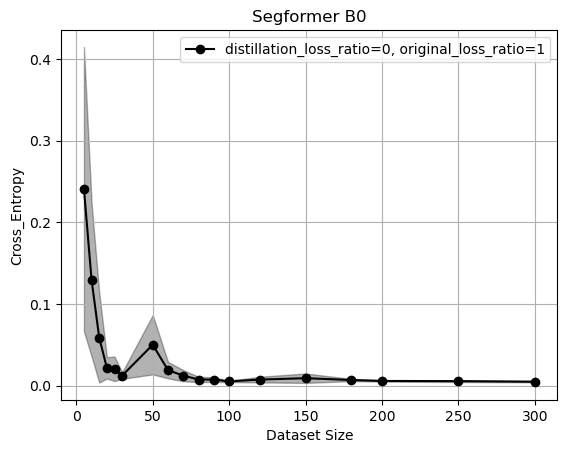

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()